<a href="https://colab.research.google.com/github/unrebby/data/blob/main/homework_practice_04_linclass_AntonovaEvgeniya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
# !pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


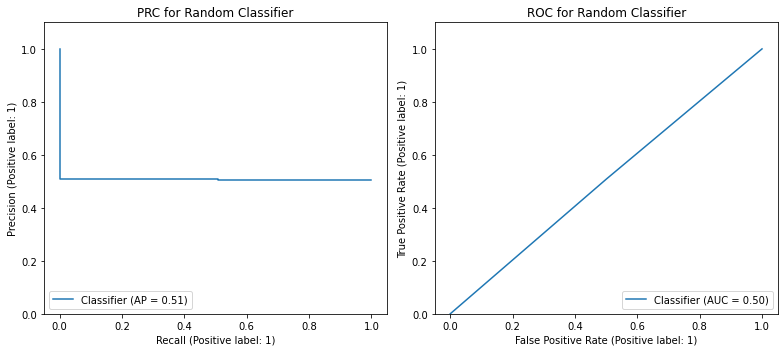

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [7]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [8]:
#your code here
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [9]:
res = 0
c_res = 0
for c_now in np.arange(0.0001, 1, 0.05):
  model_ = SVC(C=c_now, kernel = 'linear')
  model_.fit(X_train, y_train)
  precision, recall, thresholds = precision_recall_curve(y_val, model_.decision_function(X_val))
  auc_precision_recall = auc(recall, precision)
  if res < auc_precision_recall:
    res = auc_precision_recall
    c_res = c_now

c_res

0.0001

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [10]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

In [11]:
#your code here
model_ = SVC(C=c_res, kernel = 'linear')
model_.fit(X_train, y_train)

SVC(C=0.0001, kernel='linear')

AUC-PR: 0.83207
AUC-ROC: 0.83899


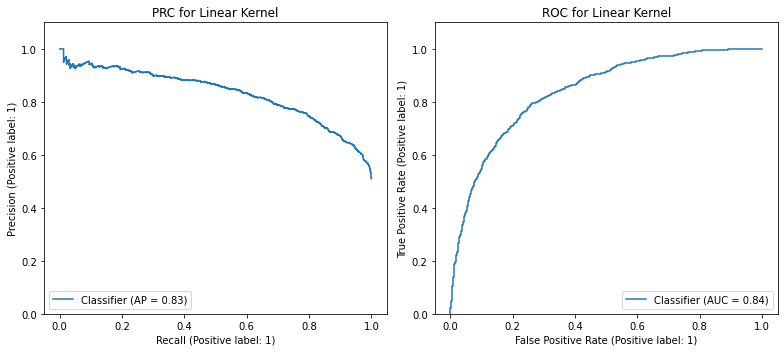

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, model_.decision_function(X_test), ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, model_.decision_function(X_test))
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Linear Kernel")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, model_.decision_function(X_test), ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, model_.decision_function(X_test)))
ax[1].set_title("ROC for Linear Kernel")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Добавим новую строку с полученными AUC-ROC, AUC-PR в табличку, которая создавалась в начале.

In [13]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['Linear Kernel'] = [
    auc(recall, precision),
    roc_auc_score(y_test, model_.decision_function(X_test)),
    None
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear Kernel,0.832074,0.838988,NaN


__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [14]:
#your code here
from sklearn.linear_model import LogisticRegression

In [15]:
res_lr = 0
c_res_lr = 0
for c_now in np.arange(0.0001, 1, 0.05):
  model_ = LogisticRegression(C=c_now)
  model_.fit(X_train, y_train)
  precision, recall, thresholds = precision_recall_curve(y_val, model_.decision_function(X_val))
  auc_precision_recall = auc(recall, precision)
  if res_lr < auc_precision_recall:
    res_lr = auc_precision_recall
    c_res_lr = c_now

c_res_lr

0.0001

In [16]:
model_ = LogisticRegression(C=c_res_lr)
model_.fit(X_train, y_train)

LogisticRegression(C=0.0001)

AUC-PR: 0.82884
AUC-ROC: 0.83281


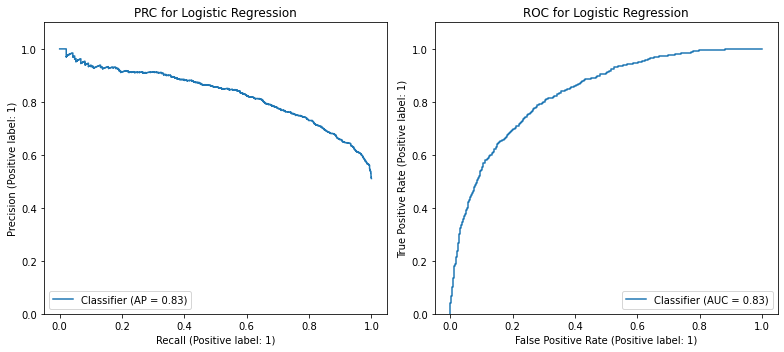

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, model_.decision_function(X_test), ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, model_.decision_function(X_test))
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Logistic Regression")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, model_.decision_function(X_test), ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, model_.decision_function(X_test)))
ax[1].set_title("ROC for Logistic Regression")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [18]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['Logistic Regression'] = [
    auc(recall, precision),
    roc_auc_score(y_test, model_.decision_function(X_test)),
    None
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear Kernel,0.832074,0.838988,NaN
Logistic Regression,0.828843,0.832806,NaN


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: SVM дал лучший результат, но буквально на одну сотую. Так что разницы практически нет.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [19]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
model_ = SVC(C=c_res, kernel = 'linear')
model_.fit(X_train, y_train)
model_.decision_function(X_test)
support_vectors = model_.support_vectors_
inds = np.where(y_train == 0)[0]
inds1 = np.where(y_train == 1)[0]

In [21]:
# разделяющая прямая
s0 = LinearSVC()
s0.fit(X_train, y_train)

w = s0.coef_[0]
line_x = list(np.arange(-4, 3, 1))
line_y = [-x * w[0] / w[0] - w[1] for x in line_x]

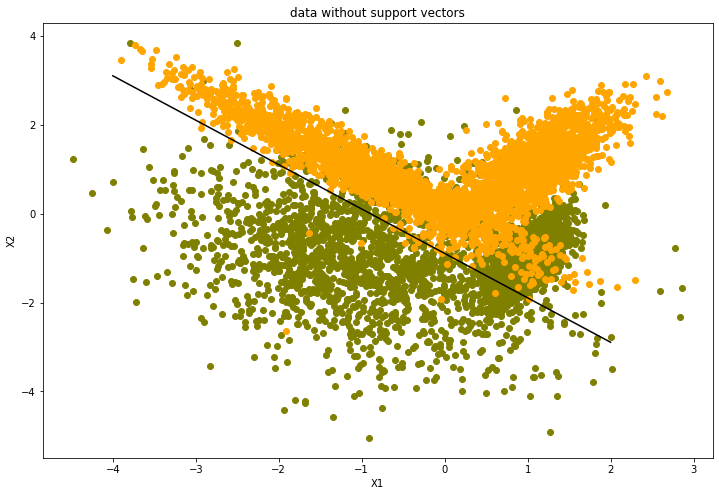

In [22]:
plt.figure(figsize = (12, 8))
x1 = X_train[:,0]
x2 = X_train[:,1]
plt.scatter(x1[inds], x2[inds], color='olive')
plt.scatter(x1[inds1], x2[inds1], color='orange')
plt.plot(line_x, line_y, color='black')
plt.title('data without support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

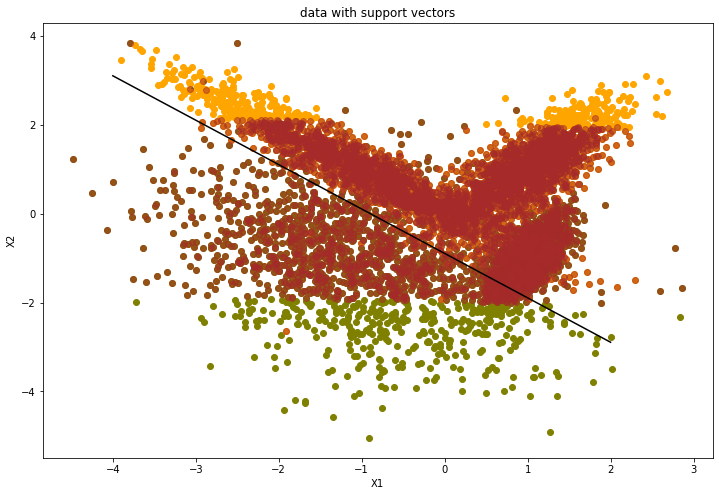

In [23]:
plt.figure(figsize = (12, 8))
x1 = X_train[:,0]
x2 = X_train[:,1]
plt.scatter(x1[inds], x2[inds], color='olive')
plt.scatter(x1[inds1], x2[inds1], color='orange')
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='brown', alpha=0.5)
plt.plot(line_x, line_y, color='black')
plt.title('data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [24]:
# другой способ нарисовать опорные векторы
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

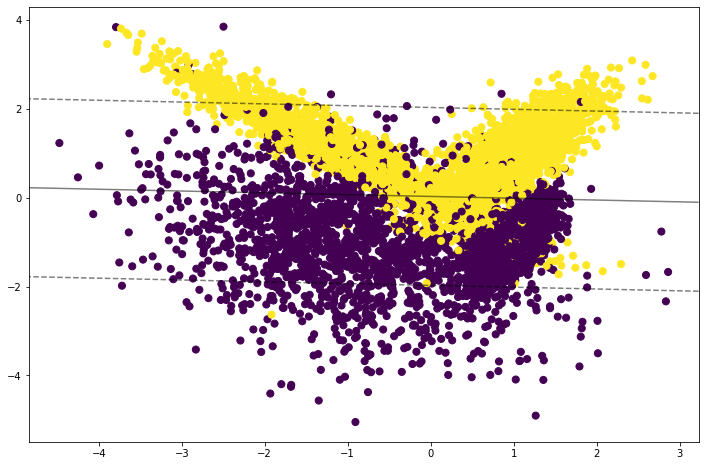

In [25]:
plt.figure(figsize = (12, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50)
plot_svc_decision_function(model_);

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [26]:
#your code here
model_lr = LogisticRegression(C=c_res_lr)
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.0001)

In [27]:
def plot_lr_decision_function(model, ax_=None, plot_support=True):
    if ax_ is None:
        ax_ = plt.gca()
    xlim = [-5,4]
    ylim = [-6,5]
    
    x = np.arange(xlim[0], xlim[1], 0.03)
    y = np.arange(ylim[0], ylim[1], 0.03)
    Y_, X_ = np.meshgrid(y, x)
    xy = np.vstack([X_.ravel(), Y_.ravel()]).T
    P = model.decision_function(xy).reshape(X_.shape)
    
    c_ = ax_.pcolor(X_, Y_, P, cmap='RdBu', vmin=0, vmax=1)
    fig.colorbar(c_, ax=ax_)
    
    ax_.set_xlim(xlim)
    ax_.set_ylim(ylim)

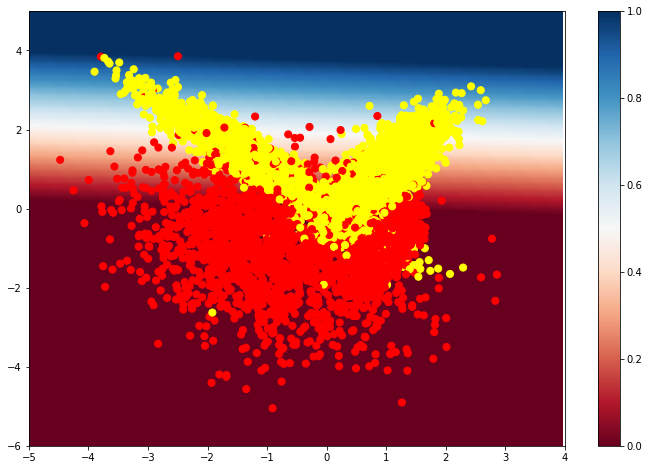

In [28]:
model_lr = LogisticRegression(C=c_res_lr)
model_lr.fit(X_train, y_train)

f, ax = plt.subplots(figsize = (12, 8))
plot_lr_decision_function(model_lr)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [29]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
#        bin_middle_points.append((l - r) / 2) # тут должна быть сумма
        bin_middle_points.append((l + r) / 2) 
#        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) # тут берем среднее, а не минимум
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)] == 1))
    return (bin_middle_points, bin_real_ratios) # делаю так, чтоб красиво построить все графики в одном окне 
#    plt.figure(figsize=(6,6))
#    plt.plot(bin_middle_points, bin_real_ratios)
#    plt.ylim([-0.05, 1.05])
#    plt.grid()


Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [30]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
model_ = SVC(kernel = 'linear')
model_.fit(X_train, y_train)
model_.decision_function(X_test)

svc_pred = model_.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min()) # переводим предсказания в [0; 1] (пользуемся масштабированием через минимум-максимум)

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

lr_pred = model_lr.predict_proba(X_test)[:, 1]

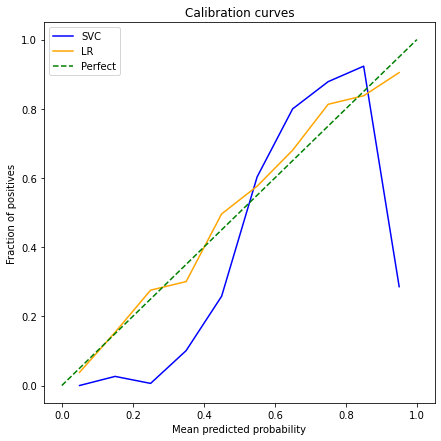

In [32]:
# с семинара
plt.figure(figsize=(7, 7))

svc_pred_prob, svc_true_prob = plot_calibration_curve(y_test, svc_pred)
lr_pred_prob, lr_true_prob = plot_calibration_curve(y_test, lr_pred)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

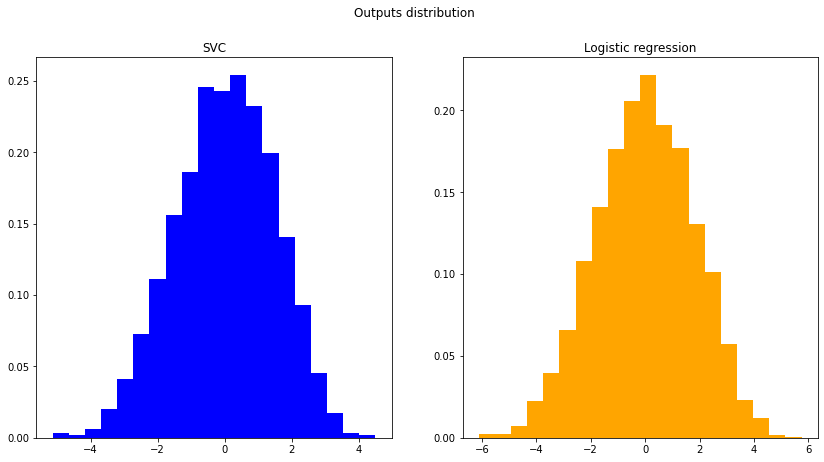

In [33]:
#your code here
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(model_.decision_function(X_test), bins=20, color='blue', density='True')
axs[1].hist(model_lr.decision_function(X_test), bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: кривая для логистической регрессии очень хорошо приближает диагональ, а калибровочная кривая для метода опорных векторов далека от неё. Это происходит из-за уверенности логистической регрессии в предсказании. У LR распределение похоже на равномерное больше, чем у SVC. Скорее всего так получается из-за методов (того, как они строятся со стороны идеи): метод опорных векторов пытается построить разделяющую гиперплоскость так, чтобы отступ был максимальным, а логистическая регрессия приближает вероятность ответов у = +1.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [34]:
#your code here
from sklearn.calibration import CalibratedClassifierCV

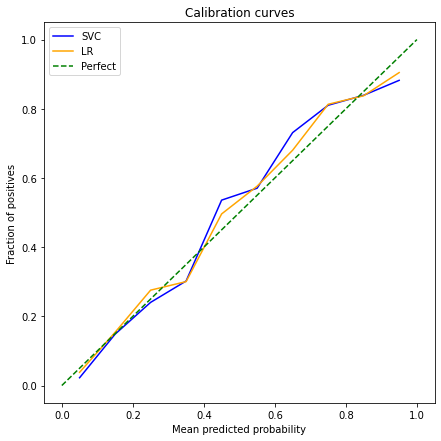

In [35]:
calibrated_svc = CalibratedClassifierCV(base_estimator=model_, cv=3)
calibrated_svc.fit(X_train, y_train)
calibrated_svc.predict_proba(X_train)[:, 1]

plt.figure(figsize=(7, 7))

svc_pred_prob_c, svc_true_prob_c = plot_calibration_curve(y_test, calibrated_svc.predict_proba(X_test)[:, 1])

plt.plot(svc_pred_prob_c, svc_true_prob_c, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Кривая теперь выглядит намного лучше (лучше приближает диагональ).

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [36]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [37]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-13 13:46:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  --.-KB/s    in 0.1s    

2022-11-13 13:46:24 (38.2 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [103]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [104]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [105]:
#your code here
train, test = train_test_split(df, test_size=0.25, random_state=777, stratify = df['income'])

X_train = train.drop(['income'], axis=1)
y_train = train['income']

X_test = test.drop(['income'], axis=1)
y_test = test['income']

In [106]:
df_encoders = pd.DataFrame(columns=['AUC_PR', 'TIME'])

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [107]:
#your code here
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

In [108]:
notnum_feats = ['workclass', 'education', 
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'native-country']

num_feats = ['age', 'fnlwgt',
           'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']


In [109]:
column_transformer = ColumnTransformer([
    ('oe', OrdinalEncoder(), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('oe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.decision_function(X_test))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.68224
TIME: 0.9128513336181641


In [110]:
df_encoders.loc['OrdinalEncoder'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851


In [111]:
print('Class balance:', y_train.mean())

Class balance: 0.24082719082719084


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: в данных присутствует выраженный дисбаланс классов, а это одно из показаний к использованию AUC-PR (поскольку PR-AUC фокусируется в основном на положительном классе).

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [112]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.decision_function(X_test))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.76713
TIME: 1.0779871940612793


In [113]:
df_encoders.loc['OneHotEncoder'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851
OneHotEncoder,0.767127,1.077987


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [114]:
#your code here
from sklearn.preprocessing import FunctionTransformer

def mean_target_encoding(df_, column):
    for column_ in column:
      mean_enc = train.groupby(column_)['income'].mean()
      df_[column_] = df_[column_].map(mean_enc)
    return (df_)

In [115]:
mean_te = FunctionTransformer(mean_target_encoding, kw_args={'column':notnum_feats})

In [116]:
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.decision_function(X_test))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.75579
TIME: 0.4845600128173828


In [117]:
df_encoders.loc['TargetEncoder'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851
OneHotEncoder,0.767127,1.077987
TargetEncoder,0.755785,0.484560


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [53]:
#your code here
# ну тут есть решение:
# https://brendanhasz.github.io/2019/03/04/target-encoding.html
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        #print(self.maps)
        return self

        
    def transform(self, X, y=None):
        X_ = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            X_[col] = vals
        return X_
            
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [118]:
column_transformer = ColumnTransformer([
    ('oe', TargetEncoder(), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('oe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.decision_function(X_test))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.75579
TIME: 0.8433468341827393


In [119]:
df_encoders.loc['TargetEncoder_optimize'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851
OneHotEncoder,0.767127,1.077987
TargetEncoder,0.755785,0.484560
TargetEncoder_optimize,0.755785,0.843347


In [56]:
te = TargetEncoder()
print('Original size:', X_train.shape)
print('Target encoded size:', te.fit_transform(X_train, y_train).shape)

Original size: (24420, 14)
Target encoded size: (24420, 14)


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [120]:
#your code here
def mean_target_encoding_with_noise(df_, column):
    train_ = train.copy()
    for column_ in column:
      mean_enc = train_.groupby(column_)['income'].mean()
      df_[column_] = df_[column_].map(mean_enc)
      df_[column_] += np.random.normal(0, 0.01, df_[column_].shape[0])
    return (df_)

In [121]:
mean_nte = FunctionTransformer(mean_target_encoding_with_noise, kw_args={'column':notnum_feats})

In [122]:
column_transformer = ColumnTransformer([
    ('ohe', mean_nte, notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.decision_function(X_test))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.75620
TIME: 0.4984321594238281


In [123]:
df_encoders.loc['TargetEncoder noise'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851
OneHotEncoder,0.767127,1.077987
TargetEncoder,0.755785,0.484560
TargetEncoder_optimize,0.755785,0.843347
TargetEncoder noise,0.756201,0.498432


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [61]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [124]:
#your code here
def mean_target_encoding_with_s(df_, column):
    train_ = train.copy()
    C = 100
    for column_ in column:
      mean_enc = (train_.groupby(column_)['income'].sum() + C * train_['income'].mean()) / (train_.groupby(column_)['income'].aggregate(np.size) + C)
      df_[column_] = df_[column_].map(mean_enc)
    return (df_)

In [125]:
mean_te_s = FunctionTransformer(mean_target_encoding_with_s, kw_args={'column':notnum_feats})

In [126]:
column_transformer = ColumnTransformer([
    ('ohe', mean_te_s, notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.75610
TIME: 0.5624828338623047


In [127]:
df_encoders.loc['TargetEncoder_s'] = [
    auc(recall, precision),
    finish - start
]

df_encoders

,AUC_PR,TIME
OrdinalEncoder,0.682238,0.912851
OneHotEncoder,0.767127,1.077987
TargetEncoder,0.755785,0.484560
TargetEncoder_optimize,0.755785,0.843347
TargetEncoder noise,0.756201,0.498432
TargetEncoder_s,0.756100,0.562483


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [128]:
#your code here
notnum_feats_upd0 = ['workclass', 'education', 
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'native-country', 'age', 'hours-per-week']

num_feats_upd0 = ['fnlwgt',
           'education-num', 'capital-gain', 
           'capital-loss']

notnum_feats_upd1 = ['workclass', 'education', 
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'native-country', 'hours-per-week']

num_feats_upd1 = ['age', 'fnlwgt',
           'education-num', 'capital-gain', 
           'capital-loss']

notnum_feats_upd2 = ['workclass', 'education', 
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'native-country', 'age']

num_feats_upd2 = ['fnlwgt',
           'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']



In [129]:
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC (age and hours are numeric): %.5f' %(auc(recall, precision)))
#-------------------------------------------------------------------------------
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats_upd0),
    ('scaling', StandardScaler(), num_feats_upd0)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC (age and hours are categorical): %.5f' %(auc(recall, precision)))
#-------------------------------------------------------------------------------
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats_upd1),
    ('scaling', StandardScaler(), num_feats_upd1)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC (age is numeric and hours is categorical): %.5f' %(auc(recall, precision)))
#-------------------------------------------------------------------------------
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats_upd2),
    ('scaling', StandardScaler(), num_feats_upd2)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC (age is categorical and hours is numeric): %.5f' %(auc(recall, precision)))

PR-AUC (age and hours are numeric): 0.75579
PR-AUC (age and hours are categorical): 0.75582
PR-AUC (age is numeric and hours is categorical): 0.75572
PR-AUC (age is categorical and hours is numeric): 0.75577


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ one-hot по времени проигрывает mean-target, а по качеству они практически идентичны (разница в 0.01). Также one-hot сильно увеличивает количество признаков, чего не происходит с mean-target, но важный минус в mean-target - это риск переобучения, чего нет у one-hot. В итоге оба способа дали хорошие результаты.


# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [68]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [69]:
#your code here
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify = y)
df_feats = pd.DataFrame(columns=['AUC_PR', 'TIME'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [70]:
#your code here
notnum_feats = ['workclass', 'education', 
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'native-country']

num_feats = ['age', 'fnlwgt',
           'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']


In [71]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
])

model_lr = pipeline.fit(X_train, y_train)

start_shape = X_train.shape
after_ohe_shape = column_transformer.transform(X_train).shape
print("Size before OneHot:", start_shape)
print("Size after  OneHot:", after_ohe_shape)
print("Count of new features:", after_ohe_shape[1] - start_shape[1])

Size before OneHot: (24420, 14)
Size after  OneHot: (24420, 102)
Count of new features: 88


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [72]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC: %.5f' %(auc(recall, precision)))

PR-AUC: 0.76713


In [73]:
df_feats.loc['start feats'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [74]:
#your code here
class top_of_w():
    def __init__(self, coefs):
        super().__init__()
        self.top = coefs.argsort()[-40:]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        tmp = X.copy()
        return tmp[:, self.top]

In [75]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.76713
TIME: 1.043090581893921


In [76]:
w_ = model_lr['regression'].coef_[0]

In [77]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('w_top', top_of_w(w_)),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
with_sc = (auc(recall, precision))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.76402
TIME: 0.6183209419250488


In [78]:
df_feats.loc['embedded method'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321


Изменилось ли качество? Как?

Качество ухудшилось на пару тысячных, но время явно улучшилось.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [79]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

model_lr = pipeline.fit(X_train, y_train)

w_ = model_lr['regression'].coef_[0]

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('w_top', top_of_w(w_)),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.68174
TIME: 0.4199256896972656


In [80]:
df_feats.loc['embedded method without scaling'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321
embedded method without scaling,0.681736,0.419926


Когда мы делали нормирование признаков, то качество было значительно лучше.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [81]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

column_transformer0 = StandardScaler(with_mean=False)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('scaling', column_transformer0),
    ('regression', LogisticRegression(max_iter=100000))
])

model_lr = pipeline.fit(X_train, y_train)

w_ = model_lr['regression'].coef_[0]

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('w_top', top_of_w(w_)),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
with_sc = (auc(recall, precision))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.76524
TIME: 0.6169025897979736


In [82]:
df_feats.loc['embedded method with scaling all'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321
embedded method without scaling,0.681736,0.419926
embedded method with scaling all,0.765243,0.616903


Качество немного улучшилось.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [83]:
#your code here
def t_(X_, target):
    t_f = []
    rng = X_.shape[1]
    for column in range(rng):
      X = X_[:, column].copy()
      num = abs(X[target == 1].mean() - X[target == 0].mean())
      n_plus = X[target == 1].shape[0]
      n_minus =  X[target == 0].shape[0]
      sigma_plus = (X[target == 1]).std()
      sigma_minus = (X[target == 0]).std()
      den = (n_plus * (sigma_plus) ** 2 + n_minus * (sigma_minus) ** 2) / (n_plus + n_minus)
      ret = num / np.sqrt(den)
      t_f.append(ret)
    return np.array(t_f)

In [84]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

X_train_transformed = column_transformer.fit_transform(X_train)
w_ = t_(X_train_transformed, y_train)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('w_top', top_of_w(w_)),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
with_sc = (auc(recall, precision))
print('PR-AUC: %.5f' %(auc(recall, precision)))
print('TIME:', finish - start)

PR-AUC: 0.76199
TIME: 0.9273867607116699


In [85]:
df_feats.loc['embedded method with filtration'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321
embedded method without scaling,0.681736,0.419926
embedded method with scaling all,0.765243,0.616903
embedded method with filtration,0.761989,0.927387


#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [86]:
#your code here
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import random

In [87]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

start = time.time()
X_train_tr = column_transformer.fit_transform(X_train)
model_lr_ =  LogisticRegression(max_iter=10000)
select_ = SequentialFeatureSelector(model_lr_,
           n_features_to_select=40,
           direction='backward',
           scoring = make_scorer(average_precision_score),
           cv = 2)
select_.fit(X_train_tr, y_train)
finish = time.time()

print('Время:', finish - start)

Время: 3634.852066516876


In [88]:
inds_ = select_.support_
sl_inds = []
for i in range(len(inds_)):
  if inds_[i] == True:
    sl_inds.append(i)

print(sl_inds)

[0, 1, 4, 5, 6, 13, 19, 20, 23, 24, 27, 29, 33, 35, 36, 37, 38, 40, 42, 43, 44, 45, 52, 54, 55, 57, 58, 62, 70, 71, 82, 86, 90, 99, 102, 103, 104, 105, 106, 107]


In [92]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])
X_train_ = pd.DataFrame(column_transformer.fit_transform(X_train))
X_test_ = pd.DataFrame(column_transformer.fit_transform(X_test))

X_train_ = X_train_.iloc[:, sl_inds]
# if X_test_.shape[1] <= (sl_inds[-1]):
#    sl_inds = sl_inds[:-1]

X_test_ = X_test_.iloc[:, sl_inds]

In [93]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train_, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test_)[:,1])
print('PR-AUC:', auc(recall, precision))
print('TIME:', finish - start)

PR-AUC: 0.6112988380384201
TIME: 1.4914991855621338


In [94]:
df_feats.loc['wrapper method_backward'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321
embedded method without scaling,0.681736,0.419926
embedded method with scaling all,0.765243,0.616903
embedded method with filtration,0.761989,0.927387
wrapper method_backward,0.611299,1.491499


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [95]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

start = time.time()
X_train_tr0 = column_transformer.fit_transform(X_train)
model_lr_0 =  LogisticRegression(max_iter=10000)
select_0 = SequentialFeatureSelector(model_lr_0,
           n_features_to_select=40,
           direction='forward',
           scoring = make_scorer(average_precision_score),
           cv = 2)
select_0.fit(X_train_tr0, y_train)
finish = time.time()

print('Время:', finish - start)

Время: 826.0218713283539


In [96]:
inds_ = select_0.support_
sl_inds = []
for i in range(len(inds_)):
  if inds_[i] == True:
    sl_inds.append(i)

print(sl_inds)

[3, 8, 12, 13, 19, 22, 23, 26, 28, 30, 35, 38, 41, 61, 62, 65, 66, 67, 69, 71, 73, 74, 75, 76, 77, 79, 80, 83, 84, 85, 88, 90, 91, 92, 94, 97, 100, 101, 105, 106]


In [97]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])
X_train_ = pd.DataFrame(column_transformer.fit_transform(X_train))
X_test_ = pd.DataFrame(column_transformer.fit_transform(X_test))

X_train_ = X_train_.iloc[:, sl_inds]
if X_test_.shape[1] <= (sl_inds[-1]):
  sl_inds = sl_inds[:-1]

X_test_ = X_test_.iloc[:, sl_inds]

In [98]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train_, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test_)[:,1])
print('PR-AUC:', auc(recall, precision))
print('TIME:', finish - start)

PR-AUC: 0.45541954313356414
TIME: 0.4674527645111084


In [99]:
df_feats.loc['wrapper method_forward'] = [
    auc(recall, precision),
    finish - start
]

df_feats

,AUC_PR,TIME
start feats,0.767127,1.055878
embedded method,0.764019,0.618321
embedded method without scaling,0.681736,0.419926
embedded method with scaling all,0.765243,0.616903
embedded method with filtration,0.761989,0.927387
wrapper method_backward,0.611299,1.491499
wrapper method_forward,0.455420,0.467453


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Метод-обёртки работал (отбирал признаки) слишком долго + дал не лучшие результаты (почему-то качество очень сильно упало). Наилучшее качество мы получили с первым методом. 

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [130]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-13 15:28:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  --.-KB/s    in 0.05s   

2022-11-13 15:28:50 (8.72 MB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/

In [131]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [132]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [133]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [134]:
notnum_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num_feats = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [135]:
# your code here
from sklearn.model_selection import KFold

cv_f = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [136]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline([
    ('ohe_ans_scaling', column_transformer),
    ('Regression', LogisticRegression(max_iter=100000))
])

plus = []
minus = []

for train_i, test_i in cv_f.split(X):
    X_train = X.loc[train_i, :]
    X_test = X.loc[test_i, :]

    model_lr = pipeline.fit(X_train, y[train_i])

    pred = model_lr.predict(X_test)
    plus.append(10 * np.sum(pred & y[test_i]))
    minus.append(1 * np.sum(pred))

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [137]:
# your code here
print('Средняя выручка:', (np.array(plus)).mean())
print('Стандартное отклонение выручки:', (np.array(plus)).std())

print('Траты:', (np.array(minus)).mean())

print('Прибыль:', (np.array(plus) - np.array(minus)).mean())
print('Стандартное отклонение прибыли:', (np.array(plus) - np.array(minus)).std())

Средняя выручка: 2130.0
Стандартное отклонение выручки: 107.144761887831
Траты: 324.2
Прибыль: 1805.8
Стандартное отклонение прибыли: 108.67640038205167


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [138]:
#your code here
plus = []
minus = []

for train_i, test_i in cv_f.split(X):
    X_train = X.loc[train_i, :]
    X_test = X.loc[test_i, :]

    model_lr = pipeline.fit(X_train, y[train_i])

    pred = model_lr.predict(X_test)
    plus.append(sum(np.random.uniform(0, 20, sum(pred & y[test_i]))))
    minus.append(np.sum(pred))

print('Средняя выручка:', (np.array(plus)).mean())
print('Стандартное отклонение выручки:', (np.array(plus)).std())

print('Траты:', (np.array(minus)).mean())

print('Прибыль:', (np.array(plus) - np.array(minus)).mean())
print('Стандартное отклонение прибыли:', (np.array(plus) - np.array(minus)).std())

Средняя выручка: 2110.996609601243
Стандартное отклонение выручки: 146.96161907695912
Траты: 324.2
Прибыль: 1786.796609601243
Стандартное отклонение прибыли: 148.70539298019528


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [139]:
#your code here
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def plus_(y_test, pred):
    return (np.sum(np.random.uniform(0, 20, sum(y_test & pred))) - np.sum(pred))

In [140]:
X_transformed = column_transformer.fit_transform(X)
C = np.logspace(-3, 2, 20)

cv_C = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": C}], scoring=make_scorer(plus_), cv=cv_f)
cv_C.fit(X_transformed, y)
best_C = cv_C.best_params_["C"]
best_C

2.636650898730358

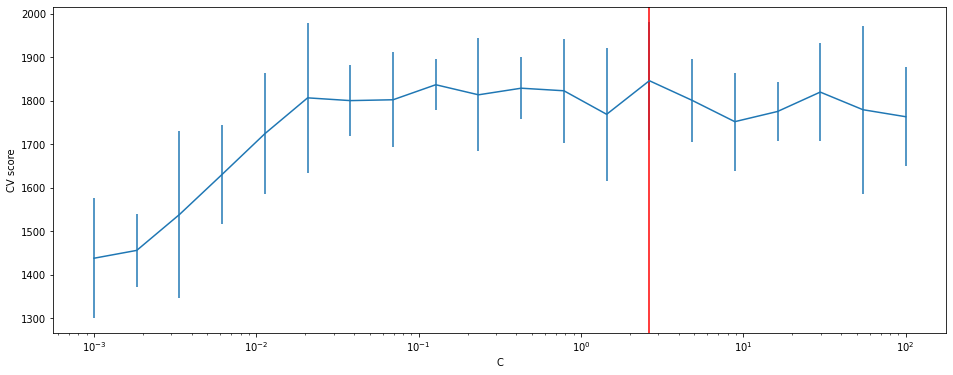

In [141]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(x=C, y=cv_C.cv_results_["mean_test_score"], yerr=cv_C.cv_results_['std_test_score'])
ax.set_xscale("log")
ax.axvline(x=best_C, c='red')

ax.set_xlabel("C")
ax.set_ylabel("CV score")
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [142]:
#your code here
for i in range(5):
    X_transformed = column_transformer.fit_transform(X)
    C = np.logspace(-3, 2, 20)

    cv_C = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": C}], scoring=make_scorer(plus_), cv=cv_f)
    cv_C.fit(X_transformed, y)
    best_C = cv_C.best_params_["C"]
    print(best_C)

100.0
4.832930238571752
0.42813323987193913
2.636650898730358
2.636650898730358


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ для нас важнее recall, потому что в случае правильного выбора мы зарабатываем 10 долларов, а в случае неправильного тратим 1.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [143]:
#your code here
grid_ = np.arange(0, 1, 0.01)

minus_ = []
plus_ = []
best_plus = 0
best_i = 0
y_mean = []
y_std = []

for i in grid_:
    plus_ = []
    minus_ = []
    for train_i, test_i in cv_f.split(X):
        X_train = X.loc[train_i, :]
        X_test = X.loc[test_i, :]

        model_lr = pipeline.fit(X_train, y[train_i])

        pred = i < model_lr.predict_proba(X_test)[:, 1]

        #pred = model_lr.predict(X_test)
        plus_.append(10 * np.sum(pred & y[test_i]))
        minus_.append(1 * np.sum(pred))

    plus = (np.array(plus_) - np.array(minus_)).mean()
    std = (np.array(plus_) - np.array(minus_)).std()
    y_mean.append(plus)
    y_std.append(std)
    
    if best_plus < plus: 
        best_plus = plus
        best_i = i

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Я запускала эту ячейку много раз, каждый раз результат одинаковый (порог равен 0.11).

0.11


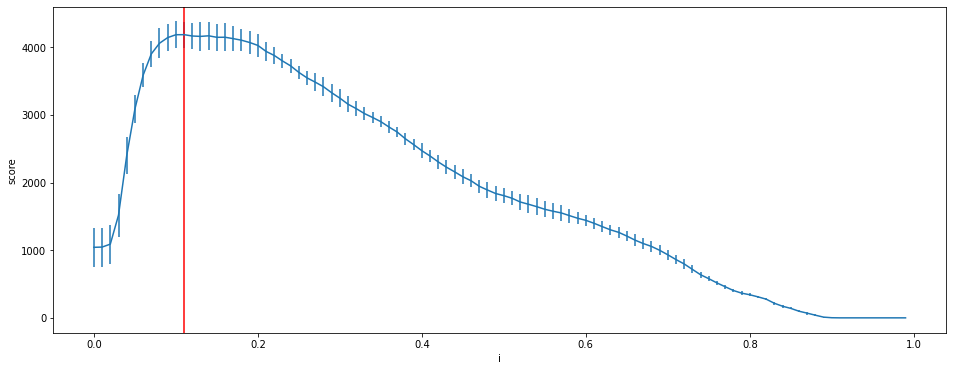

In [144]:
#your code here
print(best_i)
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(x=grid_, y=y_mean, yerr=y_std)
ax.axvline(x=best_i, c='red')

ax.set_xlabel("i")
ax.set_ylabel("score")
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [149]:
#your code here
pr = 0
rc = 0

for train_i, test_i in cv_f.split(X):
    X_train = X.loc[train_i, :]
    X_test = X.loc[test_i, :]

    model_lr = pipeline.fit(X_train, y[train_i])

    pred = best_i < model_lr.predict_proba(X_test)[:, 1]

    k = np.sum(pred & y[test_i])
    pr += k / (np.sum(pred))
    rc += k / (np.sum(y[test_i]))
    print('pr:', k / (np.sum(pred)))
    print('rc:', k / (np.sum(y[test_i])))
    print('')

pr /= 5
rc /= 5
print('Итог:')
print('precision:', pr)
print('recall:', rc)

pr: 0.3392018779342723
rc: 0.6201716738197425

pr: 0.3351032448377581
rc: 0.6187363834422658

pr: 0.3340599455040872
rc: 0.6542155816435432

pr: 0.31711229946524067
rc: 0.6723356009070295

pr: 0.3573059360730594
rc: 0.6446961894953656

Итог:
precision: 0.33655666076288354
recall: 0.6420310858615894


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

AUC-PR: 0.50117
pr: 0.3392018779342723
rc: 0.6201716738197425

AUC-PR: 0.49816
pr: 0.3351032448377581
rc: 0.6187363834422658

AUC-PR: 0.51380
pr: 0.3340599455040872
rc: 0.6542155816435432

AUC-PR: 0.51227
pr: 0.31711229946524067
rc: 0.6723356009070295

AUC-PR: 0.52194
pr: 0.3573059360730594
rc: 0.6446961894953656



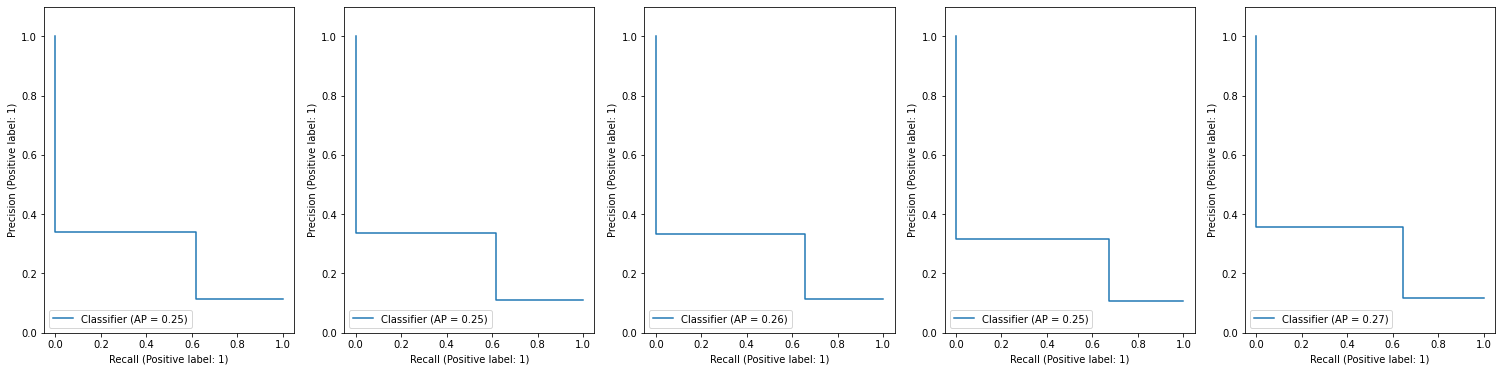

In [150]:
fig, ax = plt.subplots(1, 5, figsize=(26, 6))
i = 0
for train_i, test_i in cv_f.split(X):
    X_train = X.loc[train_i, :]
    X_test = X.loc[test_i, :]

    model_lr = pipeline.fit(X_train, y[train_i])

    pred = best_i < model_lr.predict_proba(X_test)[:, 1]


    PrecisionRecallDisplay.from_predictions(y[test_i], pred, ax=ax[i])
    precision, recall, _ = precision_recall_curve(y[test_i], pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[i].set_ylim(0, 1.1)
    i += 1

    k = np.sum(pred & y[test_i])
    pr += k / (np.sum(pred))
    rc += k / (np.sum(y[test_i]))
    print('pr:', k / (np.sum(pred)))
    print('rc:', k / (np.sum(y[test_i])))
    print('')


In [151]:
#your code here
grid_ = np.arange(0, 1, 0.01)

for i in grid_:
    rc = 0
    pr = 0
    y__ = []
    pred__ = []
    for train_i, test_i in cv_f.split(X):
        X_train = X.loc[train_i, :]
        X_test = X.loc[test_i, :]
        y__ = y[test_i]

        model_lr = pipeline.fit(X_train, y[train_i])

        pred = i < model_lr.predict_proba(X_test)[:, 1]
        pred__ = pred

        k = np.sum(pred & y[test_i])
        rc += k / (np.sum(pred))
        pr += k / (np.sum(y[test_i]))

    rc /= 5
    pr /= 5

    if rc >= 0.5:
        print('i:', i)
        print('precision:', pr)
        print('recall:', rc)
        precision, recall, _ = precision_recall_curve(y__, pred__)
        print('AUC-PR: %.5f' % auc(recall, precision))
        print('')

i: 0.32
precision: 0.4161330093796368
recall: 0.5045387093526345
AUC-PR: 0.47588

i: 0.33
precision: 0.4051007531806013
recall: 0.510420517943975
AUC-PR: 0.47718

i: 0.34
precision: 0.39586777304987414
recall: 0.5184316244872536
AUC-PR: 0.47487

i: 0.35000000000000003
precision: 0.3858915650406777
recall: 0.5279895822725579
AUC-PR: 0.47750

i: 0.36
precision: 0.3742922317701991
recall: 0.5345019053333948
AUC-PR: 0.47393

i: 0.37
precision: 0.36313179253008876
recall: 0.5435946401858255
AUC-PR: 0.47365

i: 0.38
precision: 0.3488430208918157
recall: 0.5524156982665197
AUC-PR: 0.46535

i: 0.39
precision: 0.33635575266580364
recall: 0.561806525692023
AUC-PR: 0.46230

i: 0.4
precision: 0.3234682082227365
recall: 0.5707675962614619
AUC-PR: 0.45664

i: 0.41000000000000003
precision: 0.31218890310399816
recall: 0.5792592862675805
AUC-PR: 0.45723

i: 0.42
precision: 0.29991988206273656
recall: 0.5875861560373417
AUC-PR: 0.45307

i: 0.43
precision: 0.28887715540968567
recall: 0.5962790485330292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ кофе.. много кофе..